In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
sys.path.append("/home/weixin/Documents/MyProjects/DVS_results_comparison/utils/ffdnet-pytorch/")

In [53]:
import numpy as np
import torch
from models import FFDNet
import glob
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave
import torch.nn as nn
import scipy.misc

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
################################################## load model #########################################

In [17]:
model = FFDNet(num_input_channels=1, test_mode=True)
model_save_dir = "/home/weixin/Documents/MyProjects/DVS_results_comparison/models/FFDNET/net_gray.pth"
state_dict = torch.load(model_save_dir)
device_ids = [0]
model = nn.DataParallel(model, device_ids=device_ids).cuda()
model.load_state_dict(state_dict)

In [18]:
##############################################  test dataset ##############################################

In [19]:
data_dir = "/data/nfs_examples/"
filename = ['airplane','basketball','soccer']
data_type = ['gt','pbr']
data_format = ['.npy']
preds = []
gts = []
for dt in data_type:
    for fn in filename:
        datapath = os.path.join(data_dir,fn+'_'+dt+data_format[0])
        if dt == 'gt':
            gts.append(np.load(datapath)[0])
        else:
            preds.append(np.load(datapath)[0])

In [54]:
def save_image(fig_save_dir,filename,img,para):
    fig_name = filename+'_pred_'+para+'.png'
    scipy.misc.toimage(img, cmin=np.min(img), 
                   cmax=np.max(img)).save(os.path.join(fig_save_dir,fig_name))

3 3
(250, 250)
0.982003 -0.132162 0.980392 0.0


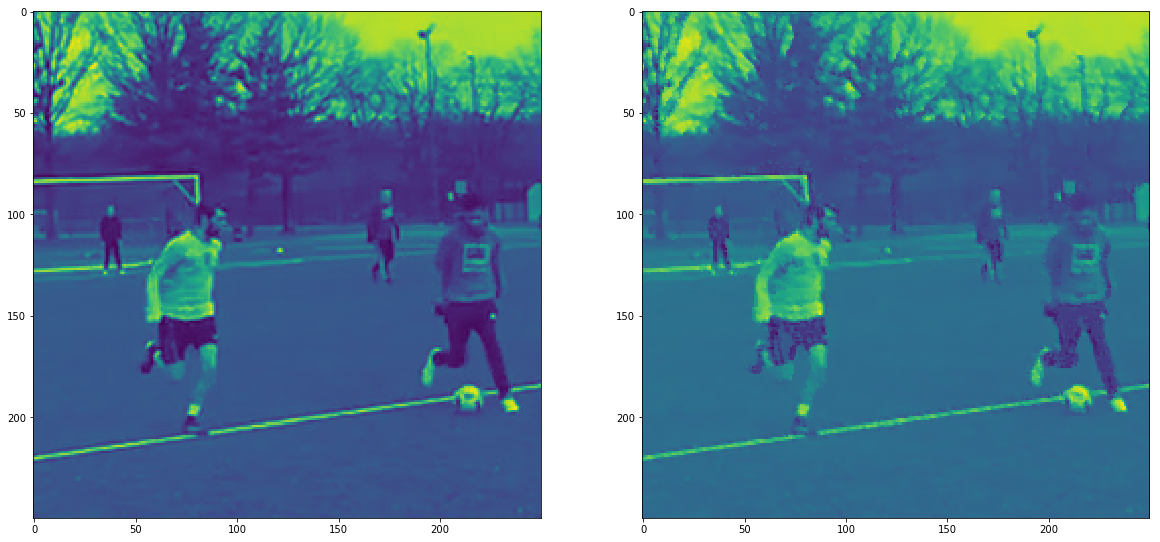

In [141]:
fig_save_dir="/home/weixin/Documents/MyProjects/DVS_results_comparison/fig"
index = 2
print(len(gts),len(preds))
print(gts[index].shape)
print(np.max(preds[index]),np.min(preds[index]),np.max(gts[index]),np.min(gts[index]))
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(gts[index])
plt.subplot(1,2,2)
plt.imshow(preds[index])

In [142]:
noisy_image = preds[index]
clean_image = gts[index]
clean_image = clean_image.astype("float32")
noisy_image = noisy_image.astype("float32")
ssim = compare_ssim(clean_image,noisy_image)
psnr = compare_psnr(clean_image,noisy_image)
print("psnr=",psnr,",ssim=",ssim)

psnr= 29.9603644852 ,ssim= 0.960660851427


In [143]:
dis_img = np.reshape(noisy_image,(1,1,*noisy_image.shape))

In [77]:
ssims = []
psnrs = []
for noise_level in range(25):
    std_var = torch.FloatTensor(np.array([noise_level/255])).to(device)
    inpt = torch.FloatTensor(dis_img).to(device)
    model = model.to(device)
    model.eval()
    noise_esti = model(inpt,std_var)
    out_val = torch.clamp(inpt-noise_esti, 0., 1.)
    predict = out_val.data.cpu().numpy()[0,0]

    ssim = compare_ssim(clean_image,predict)
    psnr = compare_psnr(clean_image,predict)
    ssims.append(ssim)
    psnrs.append(psnr)
    print("sigma =", noise_level," psnr=",psnr,",ssim=",ssim)

sigma = 0  psnr= 30.0302063232 ,ssim= 0.961248142196
sigma = 1  psnr= 30.0646411977 ,ssim= 0.961653238196
sigma = 2  psnr= 30.1375547136 ,ssim= 0.962112174756
sigma = 3  psnr= 30.2590891458 ,ssim= 0.962533534957
sigma = 4  psnr= 30.3807092565 ,ssim= 0.962316964099
sigma = 5  psnr= 30.4569576379 ,ssim= 0.96170154094
sigma = 6  psnr= 30.4991675094 ,ssim= 0.960972512431
sigma = 7  psnr= 30.5059490928 ,ssim= 0.959961325176
sigma = 8  psnr= 30.4650545234 ,ssim= 0.958398285645
sigma = 9  psnr= 30.3894802216 ,ssim= 0.95657506555
sigma = 10  psnr= 30.2898038432 ,ssim= 0.954615129306
sigma = 11  psnr= 30.1718511454 ,ssim= 0.952559037926
sigma = 12  psnr= 30.0417974711 ,ssim= 0.950390847839
sigma = 13  psnr= 29.9021011548 ,ssim= 0.94810761998
sigma = 14  psnr= 29.7574525355 ,ssim= 0.945785489577
sigma = 15  psnr= 29.6118532267 ,ssim= 0.943423875817
sigma = 16  psnr= 29.4689023837 ,ssim= 0.941053753003
sigma = 17  psnr= 29.3268256699 ,ssim= 0.938613541432
sigma = 18  psnr= 29.1829231604 ,ssim= 0.

/home/weixin/Documents/MyProjects/DVS_results_comparison/utils/ffdnet-pytorch/models.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  concat_noise_x = Variable(concat_noise_x, volatile=True)


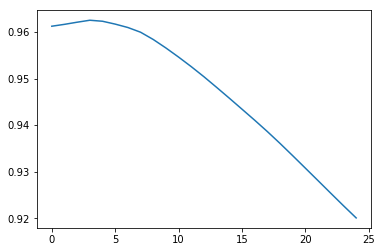

In [78]:
plt.plot(ssims)

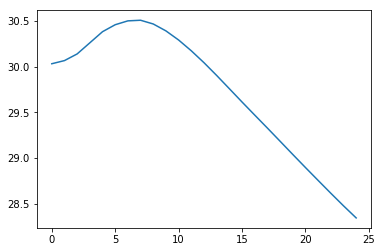

In [79]:
plt.plot(psnrs)

In [144]:
noise_level = 7
device = torch.device("cuda")

In [145]:
std_var = torch.FloatTensor(np.array([noise_level/255])).to(device)
inpt = torch.FloatTensor(dis_img).to(device)
model = model.to(device)

psnr= 30.5059490928 ,ssim= 0.959961325176


/home/weixin/Documents/MyProjects/DVS_results_comparison/utils/ffdnet-pytorch/models.py:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  concat_noise_x = Variable(concat_noise_x, volatile=True)


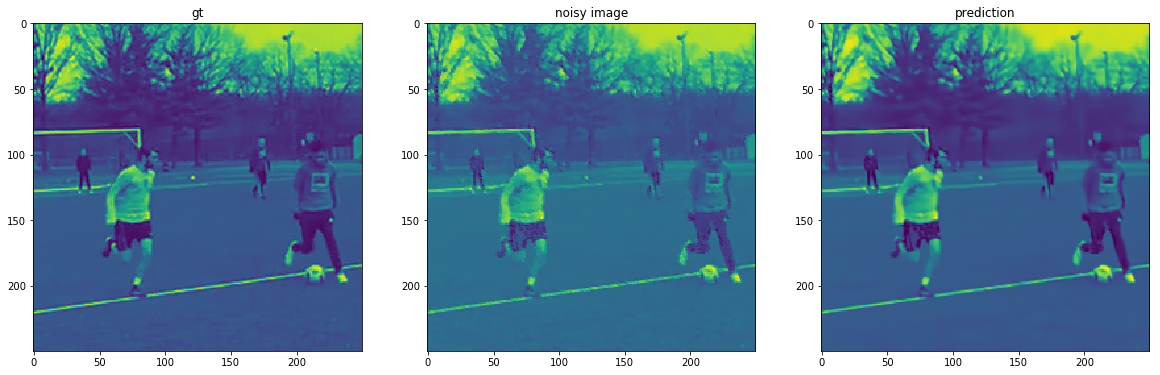

In [146]:
model.eval()
noise_esti = model(inpt,std_var)
out_val = torch.clamp(inpt-noise_esti, 0., 1.)
# psnr_val = batch_psnr(out_val, img_val, 1.)
predict = out_val.data.cpu().numpy()[0,0]
# print(predict.shape)

ssim = compare_ssim(clean_image,predict)
psnr = compare_psnr(clean_image,predict)
print("psnr=",psnr,",ssim=",ssim)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(clean_image)
plt.title("gt")
plt.subplot(1,3,2)
plt.imshow(noisy_image)
plt.title("noisy image")
plt.subplot(1,3,3)
plt.imshow(predict)
plt.title("prediction")
# save_image(fig_save_dir,filename[index],predict,'FFDNET_7')

In [ ]:
def crop_image():
    

/home/weixin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.


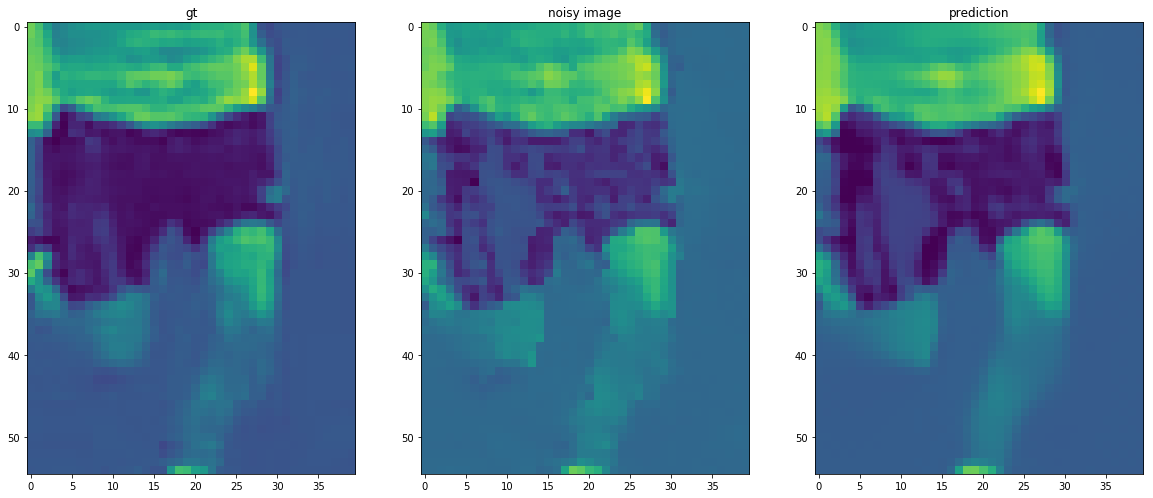

In [117]:
x1 = 140 #140 # 210
y1 = 60 #130 # 100
x2 = 195 #180 #270
y2 = 100 #190 #160

# x1 = 230
# y1 = 400
# x2 = 280
# y2 = 450

# x1 = 260
# y1 = 260
# x2 = 310
# y2 = 310
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(clean_image[x1:x2,y1:y2])
plt.title("gt")
plt.subplot(1,3,2)
plt.imshow(noisy_image[x1:x2,y1:y2])
plt.title("noisy image")
plt.subplot(1,3,3)
plt.imshow(predict[x1:x2,y1:y2])
plt.title("prediction")
tmp = predict[x1:x2,y1:y2]
save_image(fig_save_dir,filename[index],tmp,'FFDNET_p1')

/home/weixin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.


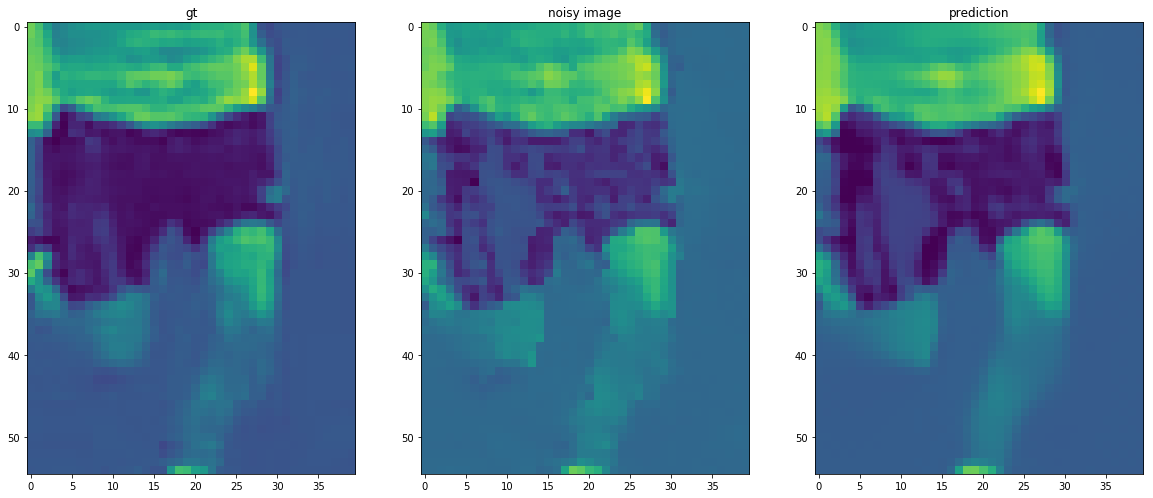

In [148]:
x1 = 140 #140 #140 # 210
y1 =  60#60 #130 # 100
x2 =  195#195 #180 #270
y2 =  100#100 #190 #160

# x1 = 230
# y1 = 400
# x2 = 280
# y2 = 450

# x1 = 260
# y1 = 260
# x2 = 310
# y2 = 310

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(clean_image[x1:x2,y1:y2])
plt.title("gt")
plt.subplot(1,3,2)
plt.imshow(noisy_image[x1:x2,y1:y2])
plt.title("noisy image")
plt.subplot(1,3,3)
plt.imshow(predict[x1:x2,y1:y2])
plt.title("prediction")

tmp = clean_image[x1:x2,y1:y2]
save_image(fig_save_dir,filename[index],tmp,'gt_p1')

tmp = noisy_image[x1:x2,y1:y2]
save_image(fig_save_dir,filename[index],tmp,'distorted_p1')